In [46]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict

### Globals

In [47]:
OUTPUT_PATH = 'outputs/'
FEATURES_PATH = 'features/'
ALGORITHMS = ['dp1', 'dp2', 'greedy', 'bf', 'bnb', 'cplex']
LEVELS = [1,2,3,4,5,6]
LEVELS_SIZE = [19198 ,9983, 6664, 4994, 3999, 3333]
FEATURES = ['num_elem',
            'cap',
            'cap_mean_w',
            'cap_median_w', 
            'cap_desv_w', 
            'mean_w_mean_v',
            'median_w_median_v', 
            'desv_w_desv_v',
            'max_w_min_w',
            'max_v_min_v',
            'mean_w',
            'median_w', 
            'desv_w', 
            'min_w', 
            'max_w', 
            'mean_v', 
            'median_v', 
            'desv_v', 
            'min_v', 
            'max_v',
            'p_coef' 
           ]

### Helpers

In [59]:
def get_features(lvl, id_):
    return np.array(open(FEATURES_PATH +str(lvl)+'/'+ str(id_),'r').read().split(), dtype=float)

def get_best(lvl, id_, t):
    best_fo = 0
    best_alg = 0
    best_time = 1000000
    for alg in ALGORITHMS:
        if lvl not in list(alg_data[alg].keys()): continue
        for res in alg_data[alg][lvl][id_]:
            if res[1] < t and res[0] >= best_fo:
                if res[1] < best_time:
                    best_alg = ALGORITHMS.index(alg)+1
                    best_time = res[1]
    return best_alg

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Reading outputs

In [49]:
output_files = os.listdir(OUTPUT_PATH)
alg_data = defaultdict(list)

print("Faltan los siguientes resultados:")
for alg in ALGORITHMS:
    alg_data[alg] = defaultdict(list)
    for lvl in LEVELS:
        filename = alg + "_" + str(lvl)
        if filename not in output_files: # En caso de que todavía no hayan resultados
            print(alg, lvl)
            continue
        alg_data[alg][lvl] = defaultdict(list)
        file = open(OUTPUT_PATH+filename,'r')
        for row in file:
            id_, fo, time = row.split()
            alg_data[alg][lvl][int(id_)].append([(float)(fo), (float)(time)])

Faltan los siguientes resultados:
dp1 6
dp2 3
dp2 4
dp2 5
dp2 6
greedy 5
greedy 6
cplex 5
cplex 6


In [61]:
train_data = []
train_label = []

count = 0

for lvl in LEVELS:
    print("level "+str(lvl)+"...")
    for id_ in range(LEVELS_SIZE[lvl-1]):
        fts = get_features(lvl, id_)
        for t in np.linspace(0.01,3,100):
            train_data.append([*fts, t+1])
            train_label.append(get_best(lvl, id_, t))
        count += 1

level 1...
level 2...
level 3...
level 4...
level 5...
level 6...


In [60]:
# comparing al ojo
lvl_ = 1
id_ = 100
for alg in ALGORITHMS:
    print(alg, alg_data[alg][lvl_][id_])
    
print('BEST: ',ALGORITHMS[get_best(lvl_,id_,1)-1])

dp1 [[753.0, 4e-05]]
dp2 [[753.0, 0.000521]]
greedy [[753.0, 4.8e-05]]
bf [[-1.0, -1.0]]
bnb [[753.0, 0.00126]]
cplex [[3426.0, 0.01586], [753.0, 0.016543]]
BEST:  dp1


In [91]:
data = pd.DataFrame(data=train_data, columns=[*FEATURES, 't'])

## NN

In [39]:

# TensorFlow and tf.keras# Tensor 
import tensorflow as tf
#from tensorflow import keras
#from keras.layers import Dropout, Dense
from keras import Sequential
from keras.models import Model   
from keras.layers import *
# Helper libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Train and Test set

In [62]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.33, random_state=42)

### Saving

In [63]:
with open('X_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, X_train)
with open('X_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, X_test)
with open('y_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_train)
with open('y_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_test)

### Loading

In [16]:
y_train = np.loadtxt('y_train.csv', dtype=float)

In [17]:
X_train = np.loadtxt('X_train.csv', dtype=float)

### Model

In [68]:
model = Sequential([
    Dense(128, input_shape = (22,), activation=tf.nn.relu),
    Dropout(0.5), #parametro prob de activacion
    Dense(128, activation=tf.nn.relu),
    Dropout(0.5), 
    Dense(7, activation=tf.nn.softmax)
])

In [69]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(np.array(X_train), np.array(y_train), epochs=10)

Epoch 1/10
3227457/3227457 [==============================] - 133s 41us/step - loss: 10.9554 - acc: 0.3203
Epoch 2/10
3227457/3227457 [==============================] - 131s 41us/step - loss: 10.9554 - acc: 0.3203
Epoch 3/10
3227457/3227457 [==============================] - 132s 41us/step - loss: 10.9554 - acc: 0.3203
Epoch 4/10
2475584/3227457 [======================>.......] - ETA: 31s - loss: 10.9513 - acc: 0.3206

### Evaluate Accuracy

In [22]:
X_test = np.loadtxt('X_test.csv', dtype=float)
y_test = np.loadtxt('y_test.csv', dtype=float)

In [44]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

1589643/1589643 [==============================] - 22s 14us/step
Test accuracy: 0.7959806069664324


In [24]:
sample = np.array(X_test[0])
sample = (np.expand_dims(sample,0))
predictions_single = model.predict(sample)

print(predictions_single)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [30]:
y_test[0]

6.0

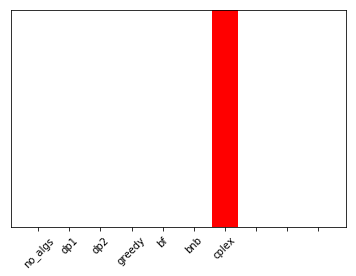

In [29]:
plot_value_array(0, predictions_single, np.array([1]))
_ = plt.xticks(range(10), ['no_algs',*ALGORITHMS], rotation=45)